### This notebook includes following steps:
- Exploratory Data Analysis
- Data Cleaning
- Data Preprocessing
- Model Creation
- Model Training
- Model Evaluation and Selection

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
ROOT = "/content/drive/MyDrive/Machine Learning Projects/Myers-Briggs Personality Classification/"
DATA = 'https://raw.githubusercontent.com/Neoanarika/MBTI/master/mbti_1.csv'
MODEL = ROOT+'saved-models/'

## Importing Libraries

In [3]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install nltk==3.6.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter
from itertools import chain
import contractions
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.collocations import TrigramAssocMeasures, TrigramCollocationFinder
from nltk import ngrams

## Load Dataset

In [6]:
data = pd.read_csv("https://raw.githubusercontent.com/Neoanarika/MBTI/master/mbti_1.csv")
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


### some information about dataset

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [8]:
data.describe()

,type,posts
count,8675,8675
unique,16,8675
top,INFP,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
freq,1832,1


### Class Distribution

In [9]:
_classes = data.type.unique()
print(_classes)

['INFJ' 'ENTP' 'INTP' 'INTJ' 'ENTJ' 'ENFJ' 'INFP' 'ENFP' 'ISFP' 'ISTP'
 'ISFJ' 'ISTJ' 'ESTP' 'ESFP' 'ESTJ' 'ESFJ']


In [10]:
def show_class_distribution(data, x="type", figsize=(16,4), title="Distribution of Personality Types", xticks_size=10, palette="husl"):
    plt.figure(figsize=figsize)
    sns.countplot(x=x, data=data, palette=palette)
    plt.xlabel("Personality Types", size=15)
    plt.ylabel("Counts", size=15)
    plt.xticks(size=xticks_size)
    plt.title(title, size=20)
    plt.show()

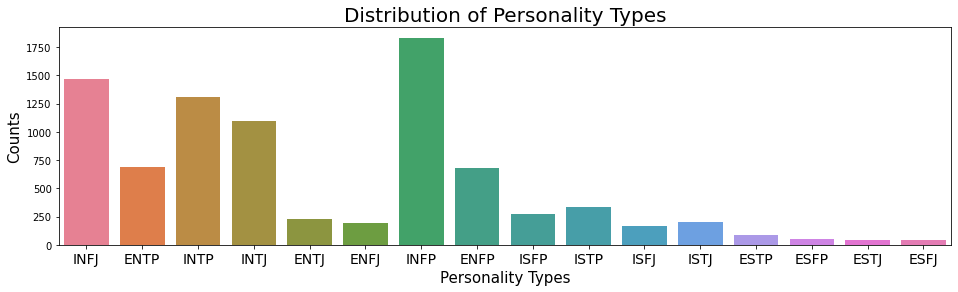

In [11]:
show_class_distribution(data, xticks_size=14)

In [12]:
def divide_types(df):
    df["E-I"] = ""
    df["N-S"] = ""
    df["F-T"] = ""
    df["J-P"] = ""
    for index, row in df.iterrows():
        row["E-I"] = "E" if row.type[0] == "E" else "I"
        row["N-S"] = "N" if row.type[1] == "N" else "S"
        row["F-T"] = "F" if row.type[2] == "F" else "T"
        row["J-P"] = "J" if row.type[3] == "J" else "P"
    return df

data = divide_types(data)

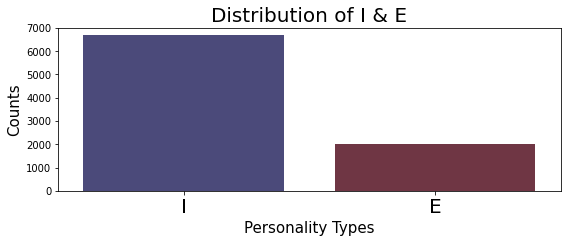

In [13]:
show_class_distribution(data, x="E-I", title="Distribution of I & E", figsize=(9,3), xticks_size=20, palette="icefire")

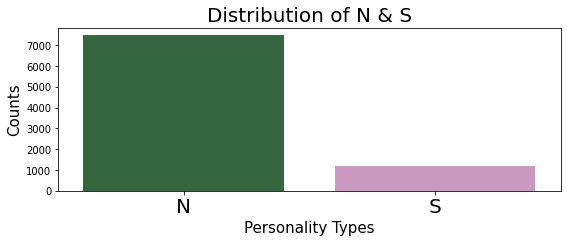

In [14]:
show_class_distribution(data, x="N-S", title="Distribution of N & S", figsize=(9,3), xticks_size=20, palette="cubehelix")

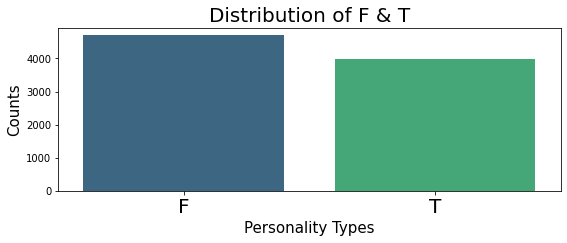

In [15]:
show_class_distribution(data, x="F-T", title="Distribution of F & T", figsize=(9,3), xticks_size=20, palette="viridis")

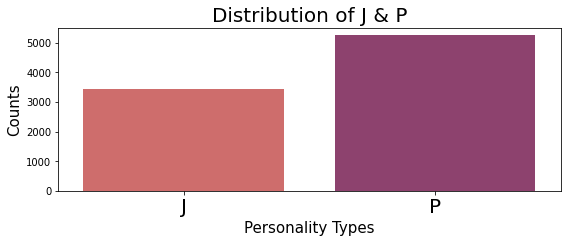

In [16]:
show_class_distribution(data, x="J-P", title="Distribution of J & P", figsize=(9,3), xticks_size=20, palette="flare")

### sample post

In [17]:
data.loc[7, "posts"]

"'I tend to build up a collection of things on my desktop that i use frequently and then move them into a folder called  'Everything' from there it get sorted into type and sub type|||i ike to collect odd objects, even at work...a lot of people would call it junk but i like to collect it.  Old unused software? ill take that off your hands :) i have a bunch of old adobe...|||i think its quite normal, i tend to only see my friends in real life every couple of months, as said earlier some people just dont get it but the good ones do :)  Edit: i mostly mean tolerate it...|||where do we go when we sleep? is dreaming another form of being awake? how many more layers of this are there if any?   thoughts about sleep keep me up at night  Edit: sometimes im too scared...|||thanks|||i wish i was free to follow my interests as i desired  i feel as though wishes are meant for impossible things|||by seeing do you mean visual interpreting or seeing as in mentally understanding the concept?|||hello|||

## Cleaning

In [18]:
def fix_contractions(df, column_name = "posts", new_column="cleaned_post"):
    df[new_column] = df[column_name].apply(lambda x: contractions.fix(x))
    return df

data = fix_contractions(data)

In [19]:
def clean_data(df, column_name = "cleaned_post"):
    df[column_name] = df[column_name].apply(lambda x: x.lower())
    df[column_name] = df[column_name].apply(lambda x: re.sub(r'@([a-zA-Z0-9_]{1,50})', '', x))
    df[column_name] = df[column_name].apply(lambda x: re.sub(r'#([a-zA-Z0-9_]{1,50})', '', x))
    df[column_name] = df[column_name].apply(lambda x: re.sub(r'http[s]?://\S+', '', x))
    df[column_name] = df[column_name].apply(lambda x: re.sub(r'[^A-Za-z]+', ' ', x))
    df[column_name] = df[column_name].apply(lambda x: re.sub(r' +', ' ', x))
    df[column_name] = df[column_name].apply(lambda x: " ".join([word for word in x.split() if not len(word) <3]))
    return df

data = clean_data(data)

### cleaned post

In [20]:
data.loc[7,"cleaned_post"]

'tend build collection things desktop that use frequently and then move them into folder called everything from there get sorted into type and sub type ike collect odd objects even work lot people would call junk but like collect old unused software ill take that off your hands have bunch old adobe think its quite normal tend only see friends real life every couple months said earlier some people just not get but the good ones edit mostly mean tolerate where when sleep dreaming another form being awake how many more layers this are there any thoughts about sleep keep night edit sometimes too scared thanks wish was free follow interests desired feel though wishes are meant for impossible things seeing you mean visual interpreting seeing mentally understanding the concept hello feel though incapable creating anything and wish could cannot stand the interviewer christ that laugh intj hmmm would interesting see intj this show doubt they would that interesting the general public though know

In [21]:
data["words_count"] = data["cleaned_post"].apply(lambda x: len(x.split()))
data.head(5)

,type,posts,E-I,N-S,F-T,J-P,cleaned_post,words_count
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,I,N,F,J,and intj moments sportscenter not top ten play...,454
1,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P,finding the lack these posts very alarming sex...,874
2,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P,good one course which say know that blessing a...,653
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",I,N,T,J,dear intp enjoyed our conversation the other d...,820
4,ENTJ,'You're fired.|||That's another silly misconce...,E,N,T,J,you are fired that another silly misconception...,782


In [22]:
def plot_counts(df, column, xlabel):
    fig = plt.figure()
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    df[column].plot.hist(bins=25)

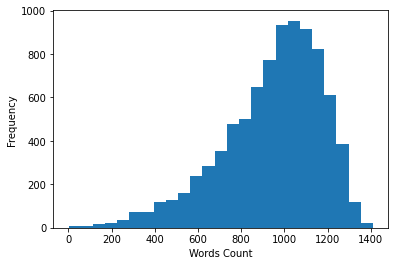

In [23]:
plot_counts(data, column="words_count", xlabel="Words Count")

In [24]:
data["char_count"] = data["cleaned_post"].apply(lambda x: len(x))
data.head(5)

,type,posts,E-I,N-S,F-T,J-P,cleaned_post,words_count,char_count
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,I,N,F,J,and intj moments sportscenter not top ten play...,454,2764
1,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P,finding the lack these posts very alarming sex...,874,5104
2,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P,good one course which say know that blessing a...,653,4000
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",I,N,T,J,dear intp enjoyed our conversation the other d...,820,4938
4,ENTJ,'You're fired.|||That's another silly misconce...,E,N,T,J,you are fired that another silly misconception...,782,4692


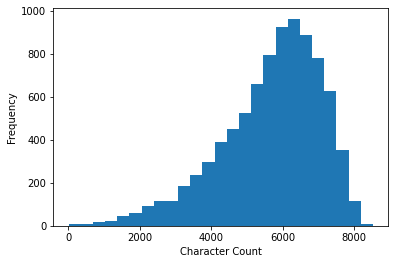

In [25]:
plot_counts(data, column="char_count", xlabel="Character Count")

### Most Frequent Words

In [26]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
stopword_list = stopwords.words("english")

In [28]:
def get_most_frequent(data, stop_words, column="cleaned_post", top=25):
    df = data[column].apply(lambda x: " ".join([word for word in x.split() if not word in stop_words]))
    counter = Counter(" ".join(df).split())
    return counter.most_common(top)

In [29]:
most_frequents = get_most_frequent(data, stopword_list)
most_frequents[:10]

[('like', 69678),
 ('would', 52964),
 ('think', 49837),
 ('people', 48150),
 ('know', 38174),
 ('one', 37173),
 ('really', 35343),
 ('get', 30806),
 ('time', 27610),
 ('feel', 23337)]

In [30]:
def show_most_frequents(most_frequent_words, top=20):
    most_frequent_df = pd.DataFrame(most_frequent_words)    
    plt.figure(figsize=(16,4))
    my_cmap = plt.get_cmap("viridis")
    plt.bar(x=most_frequent_df.iloc[:top, 0], height=most_frequent_df.iloc[:top, 1], color="slateblue")
    plt.xlabel("Words", size=17)
    plt.ylabel("Counts", size=17)
    plt.title("Most Frequent Words", size = 20)
    plt.show()

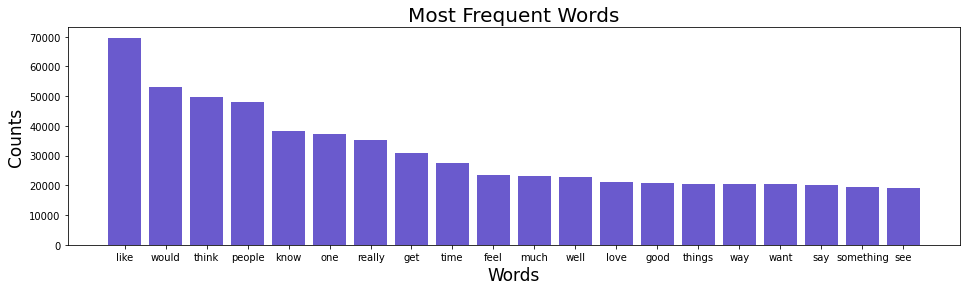

In [31]:
show_most_frequents(most_frequents)

### WordClouds

In [32]:
def show_wordcloud(data, stopword_list, column="cleaned_post"):
    fig = plt.figure(figsize=(15,5))
    wordcloud = WordCloud(background_color="black", min_font_size=5, stopwords=stopword_list).generate(data[column].to_string())
    plt.axis("off")
    plt.imshow(wordcloud)
    plt.show()

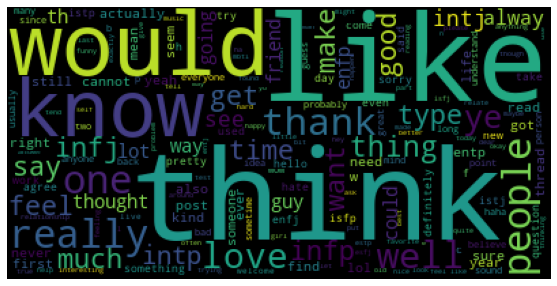

In [33]:
show_wordcloud(data, stopword_list)

In [34]:
def show_sub_wordclouds(data, type_column, column, size, fig_size=(20,15)):
    classes = data[type_column].unique()
    fig, ax = plt.subplots(len(classes), figsize=fig_size)
    j = 0
    for _class in classes:
        temp = data[data[type_column] == _class]
        wordcloud = WordCloud(background_color="black").generate(temp[column].to_string())
        plt.subplot(*size, j+1)
        plt.title(_class, size=25)
        plt.imshow(wordcloud)
        plt.axis("off")
        j+=1

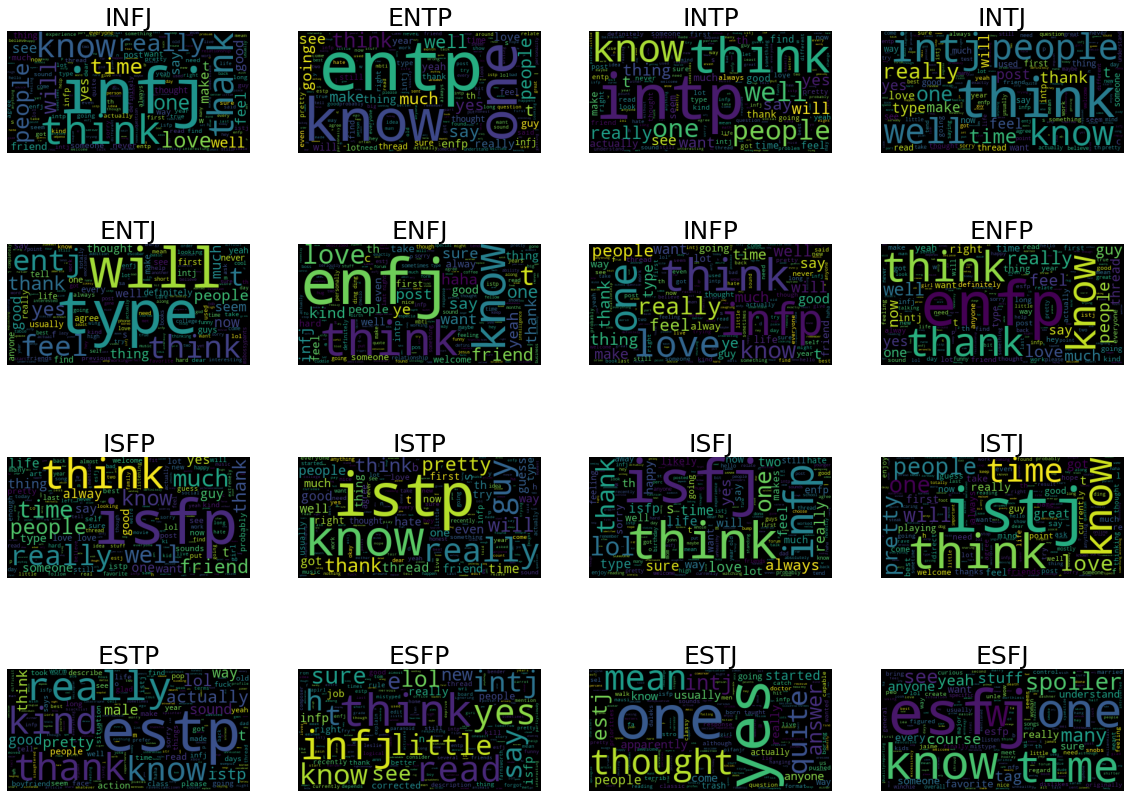

In [35]:
show_sub_wordclouds(data, type_column="type" , column="cleaned_post", size=(4,4))

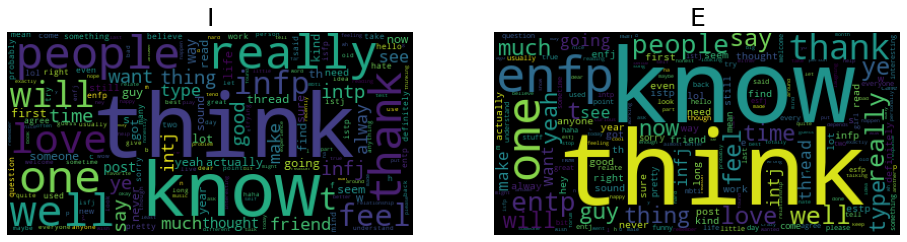

In [36]:
show_sub_wordclouds(data, type_column="E-I" , column="cleaned_post", size=(1,2), fig_size=(16,8))

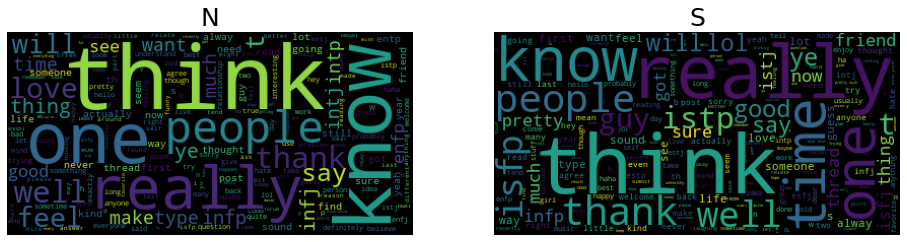

In [37]:
show_sub_wordclouds(data, type_column="N-S" , column="cleaned_post", size=(1,2), fig_size=(16,8))

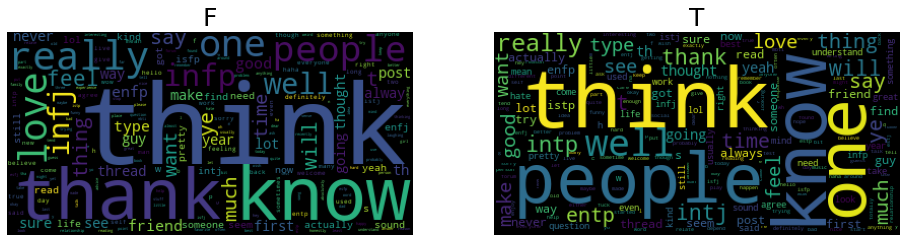

In [38]:
show_sub_wordclouds(data, type_column="F-T" , column="cleaned_post", size=(1,2), fig_size=(16,8))

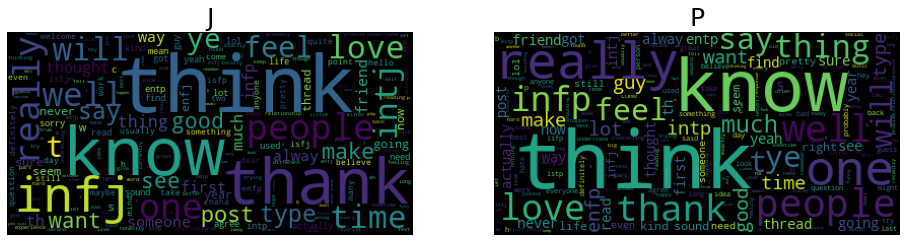

In [39]:
show_sub_wordclouds(data, type_column="J-P" , column="cleaned_post", size=(1,2), fig_size=(16,8))

### N-Grams

In [40]:
def get_ngrams(data, n_gram, new_column, column="cleaned_post"):
    data["tokenized"]  = data[column].apply(lambda x: x.split())
    data["sw_removal"] = data["tokenized"].apply(lambda x: [y for y in x if not y in stopword_list])
    data[new_column]   = data["sw_removal"].apply(lambda x: list(ngrams(x, n_gram)))
    data.drop(columns  = ["tokenized", "sw_removal"], inplace=True)
    return data

In [41]:
data = get_ngrams(data, n_gram=2, new_column="bigrams")
data.head()

,type,posts,E-I,N-S,F-T,J-P,cleaned_post,words_count,char_count,bigrams
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,I,N,F,J,and intj moments sportscenter not top ten play...,454,2764,"[(intj, moments), (moments, sportscenter), (sp..."
1,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P,finding the lack these posts very alarming sex...,874,5104,"[(finding, lack), (lack, posts), (posts, alarm..."
2,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P,good one course which say know that blessing a...,653,4000,"[(good, one), (one, course), (course, say), (s..."
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",I,N,T,J,dear intp enjoyed our conversation the other d...,820,4938,"[(dear, intp), (intp, enjoyed), (enjoyed, conv..."
4,ENTJ,'You're fired.|||That's another silly misconce...,E,N,T,J,you are fired that another silly misconception...,782,4692,"[(fired, another), (another, silly), (silly, m..."


In [42]:
data = get_ngrams(data, n_gram=3, new_column="trigrams")
data.head()

,type,posts,E-I,N-S,F-T,J-P,cleaned_post,words_count,char_count,bigrams,trigrams
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,I,N,F,J,and intj moments sportscenter not top ten play...,454,2764,"[(intj, moments), (moments, sportscenter), (sp...","[(intj, moments, sportscenter), (moments, spor..."
1,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P,finding the lack these posts very alarming sex...,874,5104,"[(finding, lack), (lack, posts), (posts, alarm...","[(finding, lack, posts), (lack, posts, alarmin..."
2,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P,good one course which say know that blessing a...,653,4000,"[(good, one), (one, course), (course, say), (s...","[(good, one, course), (one, course, say), (cou..."
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",I,N,T,J,dear intp enjoyed our conversation the other d...,820,4938,"[(dear, intp), (intp, enjoyed), (enjoyed, conv...","[(dear, intp, enjoyed), (intp, enjoyed, conver..."
4,ENTJ,'You're fired.|||That's another silly misconce...,E,N,T,J,you are fired that another silly misconception...,782,4692,"[(fired, another), (another, silly), (silly, m...","[(fired, another, silly), (another, silly, mis..."


In [43]:
def most_common_ngram(data, column, top=20):
    temp = []
    for index, row in data.iterrows():
        temp += row[column]
    most_common = Counter(temp).most_common(top)
    return most_common

In [44]:
def plot_n_grams(ngrams, title, top=20):
    ngram_df = pd.DataFrame(ngrams)
    ngram_df.iloc[:, 0] = ngram_df.iloc[:,0].astype(str)
    plt.figure(figsize=(7,7))
    plt.barh(y=ngram_df.iloc[:top, 0], width=ngram_df.iloc[:top, 1])
    plt.xlabel("Counts", size=17)
    plt.ylabel("Pairs", size=17)
    plt.title(title, size = 20)
    plt.show() 

In [45]:
bigrams_most_common = most_common_ngram(data, "bigrams")
bigrams_most_common

[(('feel', 'like'), 5642),
 (('would', 'say'), 4073),
 (('would', 'like'), 3429),
 (('sounds', 'like'), 2606),
 (('pretty', 'much'), 2409),
 (('high', 'school'), 2216),
 (('even', 'though'), 1922),
 (('seems', 'like'), 1902),
 (('best', 'friend'), 1692),
 (('really', 'like'), 1576),
 (('think', 'would'), 1573),
 (('get', 'along'), 1551),
 (('years', 'ago'), 1460),
 (('long', 'time'), 1459),
 (('using', 'tapatalk'), 1376),
 (('personality', 'type'), 1337),
 (('someone', 'else'), 1272),
 (('many', 'people'), 1270),
 (('something', 'like'), 1267),
 (('people', 'think'), 1219)]

In [46]:
bigrams_most_common = most_common_ngram(data, "bigrams")
bigrams_most_common

[(('feel', 'like'), 5642),
 (('would', 'say'), 4073),
 (('would', 'like'), 3429),
 (('sounds', 'like'), 2606),
 (('pretty', 'much'), 2409),
 (('high', 'school'), 2216),
 (('even', 'though'), 1922),
 (('seems', 'like'), 1902),
 (('best', 'friend'), 1692),
 (('really', 'like'), 1576),
 (('think', 'would'), 1573),
 (('get', 'along'), 1551),
 (('years', 'ago'), 1460),
 (('long', 'time'), 1459),
 (('using', 'tapatalk'), 1376),
 (('personality', 'type'), 1337),
 (('someone', 'else'), 1272),
 (('many', 'people'), 1270),
 (('something', 'like'), 1267),
 (('people', 'think'), 1219)]

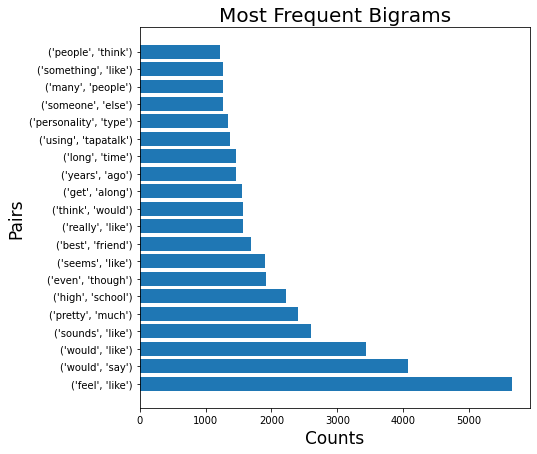

In [47]:
plot_n_grams(bigrams_most_common, title="Most Frequent Bigrams")

In [48]:
trigrams_most_common = most_common_ngram(data, "trigrams")
trigrams_most_common

[(('sent', 'iphone', 'using'), 702),
 (('iphone', 'using', 'tapatalk'), 686),
 (('sent', 'using', 'tapatalk'), 331),
 (('one', 'best', 'friends'), 280),
 (('get', 'along', 'well'), 253),
 (('sometimes', 'feel', 'like'), 207),
 (('would', 'like', 'know'), 192),
 (('long', 'time', 'ago'), 183),
 (('low', 'self', 'esteem'), 173),
 (('anything', 'may', 'affect'), 173),
 (('may', 'affect', 'way'), 171),
 (('affect', 'way', 'answer'), 168),
 (('yes', 'yes', 'yes'), 168),
 (('spend', 'lot', 'time'), 165),
 (('wikipedia', 'free', 'encyclopedia'), 162),
 (('way', 'answer', 'questions'), 158),
 (('answer', 'questions', 'example'), 150),
 (('questions', 'example', 'stressful'), 145),
 (('example', 'stressful', 'time'), 144),
 (('stressful', 'time', 'mental'), 140)]

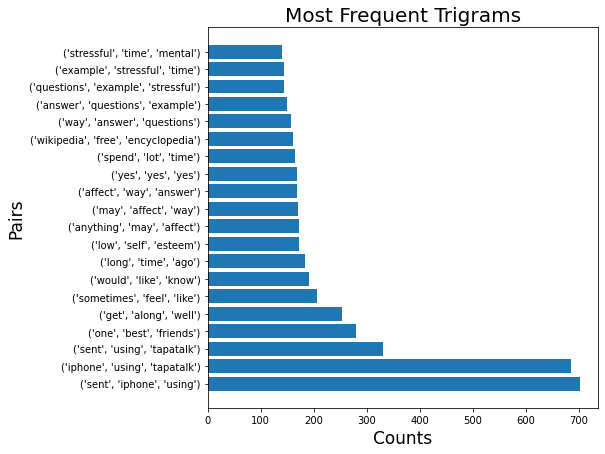

In [49]:
plot_n_grams(trigrams_most_common, title="Most Frequent Trigrams")

## preprocessing

In [50]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [51]:
def remove_stopwords(data, stopword_list, column="cleaned_post"):
    data[column] = data[column].apply(word_tokenize)
    data[column] = data[column].apply(lambda x: [word for word in x if not word in stopword_list])
    return data

In [52]:
def apply_lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

In [53]:
def lemmatize(data, stopword_list, column="cleaned_post"):
    data[column] = data[column].apply(apply_lemmatization)
    data[column] = data[column].apply(" ".join)
    return data

In [54]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [55]:
data = remove_stopwords(data, stopword_list)

In [56]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [57]:
data = lemmatize(data, stopword_list)

In [58]:
data.head()

,type,posts,E-I,N-S,F-T,J-P,cleaned_post,words_count,char_count,bigrams,trigrams
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,I,N,F,J,intj moment sportscenter top ten play prank li...,454,2764,"[(intj, moments), (moments, sportscenter), (sp...","[(intj, moments, sportscenter), (moments, spor..."
1,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P,finding lack post alarming sex boring position...,874,5104,"[(finding, lack), (lack, posts), (posts, alarm...","[(finding, lack, posts), (lack, posts, alarmin..."
2,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P,good one course say know blessing curse absolu...,653,4000,"[(good, one), (one, course), (course, say), (s...","[(good, one, course), (one, course, say), (cou..."
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",I,N,T,J,dear intp enjoyed conversation day esoteric ga...,820,4938,"[(dear, intp), (intp, enjoyed), (enjoyed, conv...","[(dear, intp, enjoyed), (intp, enjoyed, conver..."
4,ENTJ,'You're fired.|||That's another silly misconce...,E,N,T,J,fired another silly misconception approaching ...,782,4692,"[(fired, another), (another, silly), (silly, m...","[(fired, another, silly), (another, silly, mis..."


In [59]:
training_data = data[["cleaned_post", "E-I", "N-S", "F-T", "J-P"]].copy()
training_data.head(5)

,cleaned_post,E-I,N-S,F-T,J-P
0,intj moment sportscenter top ten play prank li...,I,N,F,J
1,finding lack post alarming sex boring position...,E,N,T,P
2,good one course say know blessing curse absolu...,I,N,T,P
3,dear intp enjoyed conversation day esoteric ga...,I,N,T,J
4,fired another silly misconception approaching ...,E,N,T,J


In [60]:
def make_dummies(data, columns=["E-I", "N-S", "F-T", "J-P"]):
    for column in columns:
        temp_dummy = pd.get_dummies(data[column], prefix="type")
        data = data.join(temp_dummy)
    return data

In [61]:
training_data = make_dummies(training_data)
training_data.head()

,cleaned_post,E-I,N-S,F-T,J-P,type_E,type_I,type_N,type_S,type_F,type_T,type_J,type_P
0,intj moment sportscenter top ten play prank li...,I,N,F,J,0,1,1,0,1,0,1,0
1,finding lack post alarming sex boring position...,E,N,T,P,1,0,1,0,0,1,0,1
2,good one course say know blessing curse absolu...,I,N,T,P,0,1,1,0,0,1,0,1
3,dear intp enjoyed conversation day esoteric ga...,I,N,T,J,0,1,1,0,0,1,1,0
4,fired another silly misconception approaching ...,E,N,T,J,1,0,1,0,0,1,1,0


### Handling Imbalanced Data

In [62]:
X = training_data[["cleaned_post"]]
y = training_data.drop(columns=["cleaned_post"])

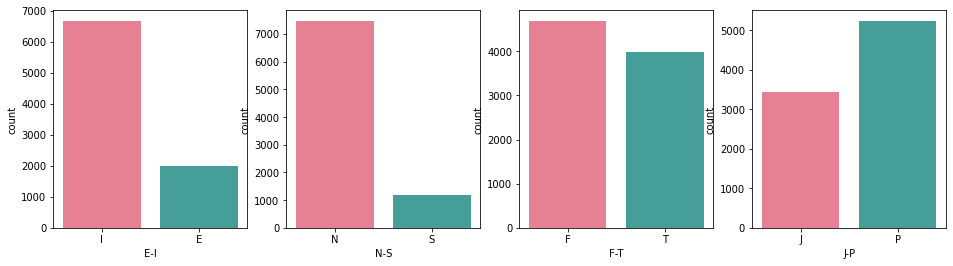

In [63]:
def show_distribution(data, x=["E-I", "N-S", "F-T","J-P"], fig_size=(16,4), xticks_size=10, palette="husl"):
    fig, ax = plt.subplots(len(x), figsize=fig_size)
    j = 0
    for _x in x:
        plt.subplot(1,4, j+1)
        sns.countplot(x=_x, data=data, palette=palette)
        plt.xticks(size=xticks_size)
        j+=1    
        
show_distribution(data)

In [64]:
from imblearn.over_sampling import RandomOverSampler


In [65]:
oversample = RandomOverSampler()

In [66]:
y_ei = y["type_E"]
y_ns = y["type_N"]
y_ft = y["type_F"]
y_jp = y["type_J"]

In [67]:
X_over_ei, y_over_ei = oversample.fit_resample(X, y_ei)
X_over_ns, y_over_ns = oversample.fit_resample(X, y_ns)
X_over_ft, y_over_ft = oversample.fit_resample(X, y_ft)
X_over_jp, y_over_jp = oversample.fit_resample(X, y_jp)

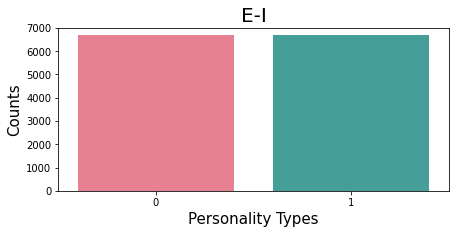

In [68]:
show_class_distribution(data=X_over_ei, x=y_over_ei, figsize=(7,3), title="E-I")

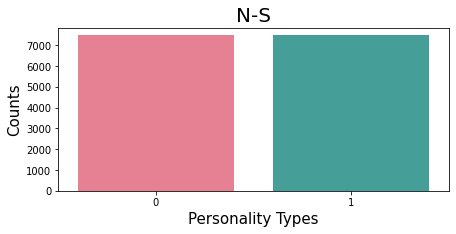

In [69]:
show_class_distribution(data=X_over_ns, x=y_over_ns, figsize=(7,3), title="N-S")

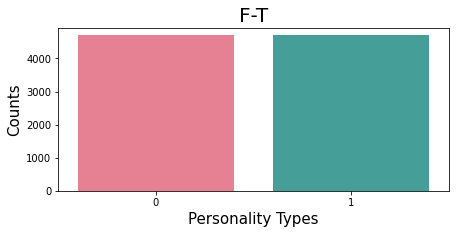

In [70]:
show_class_distribution(data=X_over_ft, x=y_over_ft, figsize=(7,3), title="F-T")

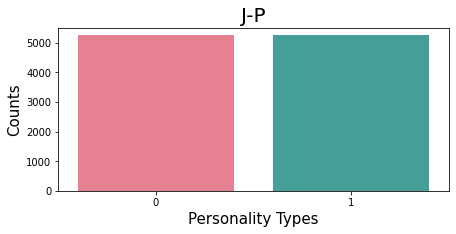

In [71]:
show_class_distribution(data=X_over_jp, x=y_over_jp, figsize=(7,3), title="J-P")

## Train-test split for each classes

In [72]:
from sklearn.model_selection import train_test_split

In [73]:
X_train_ei, X_test_ei, y_train_ei, y_test_ei = train_test_split(X_over_ei, y_over_ei, test_size=0.3, random_state=42)
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(X_over_ns, y_over_ns, test_size=0.3, random_state=42)
X_train_ft, X_test_ft, y_train_ft, y_test_ft = train_test_split(X_over_ft, y_over_ft, test_size=0.3, random_state=42)
X_train_jp, X_test_jp, y_train_jp, y_test_jp = train_test_split(X_over_jp, y_over_jp, test_size=0.3, random_state=42)

In [74]:
X_train_ei = X_train_ei['cleaned_post']
X_train_ns = X_train_ns['cleaned_post']
X_train_ft = X_train_ft['cleaned_post']
X_train_jp = X_train_jp['cleaned_post']

In [75]:
X_test_ei = X_test_ei['cleaned_post']
X_test_ns = X_test_ns['cleaned_post']
X_test_ft = X_test_ft['cleaned_post']
X_test_jp = X_test_jp['cleaned_post']

In [76]:
y_train_ei.name, y_test_ei.name = "E-I", "E-I"
y_train_ns.name, y_test_ns.name = "N-S", "N-S"
y_train_ft.name, y_test_ft.name = "F-T", "F-T"
y_train_jp.name, y_test_jp.name = "J-P", "J-P"

In [77]:
y_all_train = [y_train_ei, y_train_ns, y_train_ft,  y_train_jp]
y_all_test  = [y_test_ei, y_test_ns, y_test_ft, y_test_jp] 

## TF-IDF Vectorizer

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [79]:
vectorizer = TfidfVectorizer(max_features=10000)

In [80]:
vectorizer.fit(X_train_ei)

TfidfVectorizer(max_features=10000)

In [81]:
X_train_ei = vectorizer.transform(X_train_ei)
X_test_ei  = vectorizer.transform(X_test_ei)

X_train_ns = vectorizer.transform(X_train_ns)
X_test_ns  = vectorizer.transform(X_test_ns)

X_train_ft = vectorizer.transform(X_train_ft)
X_test_ft  = vectorizer.transform(X_test_ft)

X_train_jp = vectorizer.transform(X_train_jp)
X_test_jp  = vectorizer.transform(X_test_jp)

In [82]:
x_all_train = [X_train_ei, X_train_ns, X_train_ft, X_train_jp]
x_all_test  = [X_test_ei, X_test_ns, X_test_ft, X_test_jp]

In [83]:
tf_idf = pd.DataFrame(X_test_ei.toarray(), columns=vectorizer.get_feature_names_out())
tf_idf.head(10)

,aaand,ab,aba,aback,abandon,abandoned,abandonment,abba,abbreviation,abhor,...,zimmerman,zip,zodiac,zoe,zombie,zone,zoned,zoning,zoo,zooey
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.117562,0.0,0.0,0.045859,0.0,0.0,0.0,0.000000
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.056899,0.0,0.0,0.000000,0.0,0.0,0.0,0.069224
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


## Model Creation & Model Training & Model Saving

In [84]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost
import pickle
from sklearn import metrics

In [85]:
def create_models():
    nb_clf  = MultinomialNB(alpha=0.01)
    svm_clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    dt_clf  = DecisionTreeClassifier(max_depth=7)
    rf_clf  = RandomForestClassifier(n_estimators=750)
    xgb_clf = xgboost.XGBClassifier(use_label_encoder=False)
    return {"NaiveBayes":nb_clf, "SVM":svm_clf, "DecisionTree":dt_clf, "RandomForest":rf_clf, "Xgboost":xgb_clf}

## Model Performance Evaluation with accuracy & f1-score & roc-auc score

In [86]:
_metrics = ["Accuracy", "Accuracy", "Accuracy" ,"Accuracy", "Precision", "Precision", "Precision","Precision", "Recall","Recall","Recall","Recall", "F1-Score", "F1-Score", "F1-Score", "F1-Score", "Roc-Auc Score", "Roc-Auc Score", "Roc-Auc Score", "Roc-Auc Score"]
_types   = ["E-I", "N-S", "F-T", "J-P", "E-I", "N-S", "F-T", "J-P", "E-I", "N-S", "F-T", "J-P","E-I", "N-S", "F-T", "J-P","E-I", "N-S", "F-T", "J-P"]
_columns = ["NaiveBayes", "SVM", "DecisionTree", "RandomForest", "Xgboost"]

In [87]:
evaluation_df = pd.DataFrame(columns=_columns, index=[_metrics, _types])
evaluation_df

NaiveBayes  SVM DecisionTree RandomForest Xgboost
Accuracy      E-I        NaN  NaN          NaN          NaN     NaN
              N-S        NaN  NaN          NaN          NaN     NaN
              F-T        NaN  NaN          NaN          NaN     NaN
              J-P        NaN  NaN          NaN          NaN     NaN
Precision     E-I        NaN  NaN          NaN          NaN     NaN
              N-S        NaN  NaN          NaN          NaN     NaN
              F-T        NaN  NaN          NaN          NaN     NaN
              J-P        NaN  NaN          NaN          NaN     NaN
Recall        E-I        NaN  NaN          NaN          NaN     NaN
              N-S        NaN  NaN          NaN          NaN     NaN
              F-T        NaN  NaN          NaN          NaN     NaN
              J-P        NaN  NaN          NaN          NaN     NaN
F1-Score      E-I        NaN  NaN          NaN          NaN     NaN
              N-S        NaN  NaN          NaN          NaN     NaN
              F-T        NaN  NaN          NaN          NaN     NaN
              J-P        NaN  NaN          NaN          NaN     NaN
Roc-Auc Score E-I        NaN  NaN          NaN          NaN     NaN
              N-S        NaN  NaN          NaN          NaN     NaN
              F-T        NaN  NaN          NaN          NaN     NaN
              J-P        NaN  NaN          NaN          NaN     NaN

In [88]:
models = create_models()
models

{'DecisionTree': DecisionTreeClassifier(max_depth=7),
 'NaiveBayes': MultinomialNB(alpha=0.01),
 'RandomForest': RandomForestClassifier(n_estimators=750),
 'SVM': SVC(gamma='auto', kernel='linear'),
 'Xgboost': XGBClassifier(use_label_encoder=False)}

In [90]:
for model_item in models.items():
    for X_train, X_test, y_train, y_test in zip(x_all_train, x_all_test, y_all_train, y_all_test):
        # Model creation and prediction
        model = model_item[1]
        print(f"{model} is training for {y_train.name}...")
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        # Performance evaluation metrics
        evaluation_df.loc["Accuracy",y_train.name][model_item[0]]      = round(metrics.accuracy_score(y_test, pred), 3)
        evaluation_df.loc["Precision",y_train.name][model_item[0]]     = round(metrics.precision_score(y_test, pred), 3)
        evaluation_df.loc["Recall",y_train.name][model_item[0]]        = round(metrics.recall_score(y_test, pred), 3)        
        evaluation_df.loc["F1-Score",y_train.name][model_item[0]]      = round(metrics.f1_score(y_test, pred), 3)
        evaluation_df.loc["Roc-Auc Score",y_train.name][model_item[0]] = round(metrics.roc_auc_score(y_test, pred), 3)        
       

MultinomialNB(alpha=0.01) is training for E-I...
MultinomialNB(alpha=0.01) is training for N-S...
MultinomialNB(alpha=0.01) is training for F-T...
MultinomialNB(alpha=0.01) is training for J-P...
SVC(gamma='auto', kernel='linear') is training for E-I...
SVC(gamma='auto', kernel='linear') is training for N-S...
SVC(gamma='auto', kernel='linear') is training for F-T...
SVC(gamma='auto', kernel='linear') is training for J-P...
DecisionTreeClassifier(max_depth=7) is training for E-I...
DecisionTreeClassifier(max_depth=7) is training for N-S...
DecisionTreeClassifier(max_depth=7) is training for F-T...
DecisionTreeClassifier(max_depth=7) is training for J-P...
RandomForestClassifier(n_estimators=750) is training for E-I...
RandomForestClassifier(n_estimators=750) is training for N-S...
RandomForestClassifier(n_estimators=750) is training for F-T...
RandomForestClassifier(n_estimators=750) is training for J-P...
XGBClassifier(use_label_encoder=False) is training for E-I...
XGBClassifier(use_

In [91]:
evaluation_df

NaiveBayes    SVM DecisionTree RandomForest Xgboost
Accuracy      E-I      0.826  0.894        0.789        0.951   0.837
              N-S      0.897  0.945        0.812        0.992   0.877
              F-T      0.817  0.858        0.764        0.847   0.835
              J-P      0.734  0.809        0.738        0.837   0.803
Precision     E-I      0.829  0.881        0.802        0.986   0.857
              N-S      0.895  0.966        0.784        0.991   0.869
              F-T      0.815  0.856        0.753        0.841   0.842
              J-P      0.734  0.801        0.763        0.911   0.811
Recall        E-I      0.822  0.911         0.77        0.915    0.81
              N-S      0.901  0.924        0.865        0.993    0.89
              F-T      0.819  0.861        0.784        0.856   0.823
              J-P      0.728  0.819        0.685        0.744   0.789
F1-Score      E-I      0.826  0.896        0.786        0.949   0.833
              N-S      0.898  0.944        0.823        0.992    0.88
              F-T      0.817  0.859        0.768        0.848   0.832
              J-P      0.731   0.81        0.722        0.819     0.8
Roc-Auc Score E-I      0.826  0.894        0.789        0.951   0.837
              N-S      0.897  0.945        0.811        0.992   0.877
              F-T      0.817  0.858        0.764        0.847   0.835
              J-P      0.734  0.809        0.737        0.836   0.803

## Save Tf-Idf Vectorizer

In [92]:
filename = 'vectorizer.pkl'
pickle.dump(vectorizer,open(filename, 'wb'))